# Chapter 18 - Neural Networks


## Listing 18-1. Importing the data


In [1]:
import pandas as pd

df = pd.read_csv("jena_climate_2009_2016.csv")
df = df.drop("Date Time", axis=1)
cols = [
    "p",
    "T",
    "Tpot",
    "Tdew",
    "rh",
    "VPmax",
    "VPact",
    "VPdef",
    "sh",
    "H2OC",
    "rho",
    "wv",
    "mwv",
    "wd",
]
df.columns = cols

## Listing 18-2. Creating the lagged dataset


Goal is to forecast the temperature **12 hours later**.<br>
Create lags for each column in df: [12, 14, 16, 18, 22, 26.4] hours.<br>
Drop the first NaN 144 lines from df produced by the lags.


In [2]:
lag_steps = range(72, 144, 12)

# Generate lags and concat them back to the original df
df_lagged = pd.concat(
    [df.shift(lag).add_suffix(f".lag{lag}") for lag in lag_steps], axis=1
)

# Merge back and drop the initial rows where lags created NaNs
df = pd.concat([df, df_lagged], axis=1).iloc[144:]

y = df.loc[144:, "T"]

## Listing 18-3. Fitting the MinMaxScaler


In [3]:
# apply a min max scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

## Listing 18-4. Fitting the full PCA


In [4]:
from sklearn.decomposition import PCA
import mlflow

mlflow.autolog()

# Fit a PCA with maximum number of components
mypca = PCA()
mypca.fit(df)

2026/02/25 16:09:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2026/02/25 16:09:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/25 16:09:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/25 16:09:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/25 16:09:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/25 16:09:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/25 16:09:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/25 16:09:45 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/25 16:09:45 INFO mlflow.store.db.utils: Updating database tables
2026/02/25 16:09:45 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/25 16:09:45 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/25 16:09:45 IN

,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",None
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.linalg.svd` and select the components by postprocessing""covariance_eigh"" : Precompute the covariance matrix (on centered data), run a classical eigenvalue decomposition on the covariance matrix typically using LAPACK and select the components by postprocessing. This solver is very efficient for n_samples >> n_features and small n_features. It is, however, not tractable otherwise for large n_features (large memory footprint required to materialize the covariance matrix). Also note that compared to the ""full"" solver, this solver effectively doubles the condition number and is therefore less numerical stable (e.g. on input data with a large range of singular values).""arpack"" : Run SVD truncated to `n_components` calling ARPACK solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < min(X.shape)`""randomized"" : Run randomized SVD by the method of Halko et al... versionadded:: 0.18.0.. versionchanged:: 1.5 Added the 'covariance_eigh' solver.",'auto'
,"tol tol: float, default=0.0Tolerance for singular values computed by svd_solver == 'arpack'.Must be of range [0.0, infinity)... versionadded:: 0.18.0",0.0
,"iterated_power iterated_power: int or 'auto', default='auto'Number of iterations for the power method computed bysvd_solver == 'randomized'.Must be of range [0, infinity)... versionadded:: 0.18.0",'auto'
,"n_oversamples n_oversamples: int, default=10This parameter is only relevant when `svd_solver=""randomized""`.It corresponds to the additional number of random vectors to sample therange of `X` so as to ensure proper conditioning. See:func:`~sklearn.utils.extmath.randomized_svd` for more details... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized S

## Listing 18-5. Plotting the full PCA


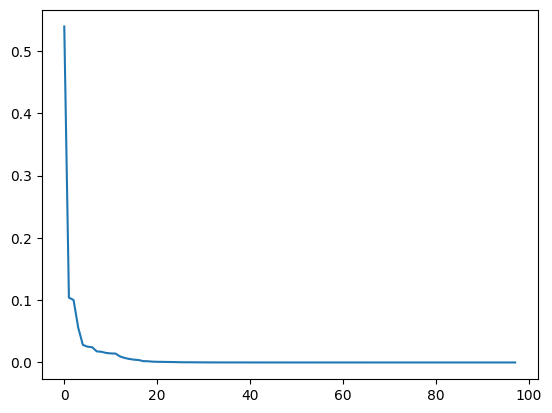

In [5]:
# Make a scree plot
import matplotlib.pyplot as plt

plt.plot(mypca.explained_variance_ratio_)
plt.show()

## Listing 18-6. Fitting the PCA with 10 components


In [6]:
mypca = PCA(10)
df = mypca.fit_transform(df)

2026/02/25 16:12:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a845162af1e144b0912f1a8a6fec1778', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2026/02/25 16:13:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\bodau\Documents\Dev\Advanced-Forecasting-with-Python-2nd-ed\Advanced-Forecasting-with-Python-2nd-ed\.venv\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
2026/02/25 16:13:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/02/25 16:13:27 WARNING mlflow.sklearn: Training metrics will n

## Listing 18-7. Train test split


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.33, random_state=42
)

## Listing 18-8. Specify the model and its architecture


In [8]:
import keras
from keras import layers

# Setting seeds for reproducibility
keras.utils.set_random_seed(42)

# We can use the 'shape' argument directly in the first layer
model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1],)),  # Explicit input layer
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1),  # Output layer for regression
    ]
)

2026/02/25 16:14:08 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: cannot import name 'cast' from partially initialized module 'keras.src.backend' (most likely due to a circular import) (c:\Users\bodau\Documents\Dev\Advanced-Forecasting-with-Python-2nd-ed\Advanced-Forecasting-with-Python-2nd-ed\.venv\Lib\site-packages\keras\src\backend\__init__.py)
2026/02/25 16:14:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


## Listing 18-9. Obtain a summary of the model architecture


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,929 (19.25 KB)

 Trainable params: 4,929 (19.25 KB)

 Non-trainable params: 0 (0.00 B)

## Listing 18-10. Compile the model


In [10]:
# Modern Keras 3 Adam often performs better with default or slightly lower LR
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss="mse",  # Using Mean Squared Error for the loss function
    metrics=["mae"],  # Using MAE for human-readable performance
)

## Listing 18-11. Fit the model


In [12]:
# This stops training automatically if the model stops improving
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Fit the model
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=10,  # Set higher, but EarlyStopping will cut it short
    batch_size=32,
    shuffle=True,
    callbacks=[early_stopping],  # Add the callback here
    verbose=1,
)

2026/02/25 16:35:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9cf4486e19ae4629b942c34fe0717c6a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow
2026/02/25 16:35:37 WARNING mlflow.keras.autologging: Failed to log dataset information to MLflow. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 1.5308 - mae: 0.9560 - val_loss: 1.5679 - val_mae: 0.9638
Epoch 2/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.5293 - mae: 0.9556 - val_loss: 1.5679 - val_mae: 0.9637
Epoch 3/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.5277 - mae: 0.9551 - val_loss: 1.5656 - val_mae: 0.9630
Epoch 4/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.5265 - mae: 0.9547 - val_loss: 1.5648 - val_mae: 0.9626
Epoch 5/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.5251 - mae: 0.9543 - val_loss: 1.5628 - val_mae: 0.9621
Epoch 6/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 1.5236 - mae: 0.9538 - val_loss: 1.5605 - val_mae: 0.9610
Epoch 7/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 1.5224 - mae: 0.9535 - val_loss: 1.5587 - val_mae: 0.9606
Epoch 8/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 1.5208 - mae: 0.9529 - val_loss: 1.5571 - val_mae: 0.9602
Epoch 9/10
7042/7042 ━━━━━━━━━━━

2026/02/25 16:39:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


## Listing 18-12. Plot the training history


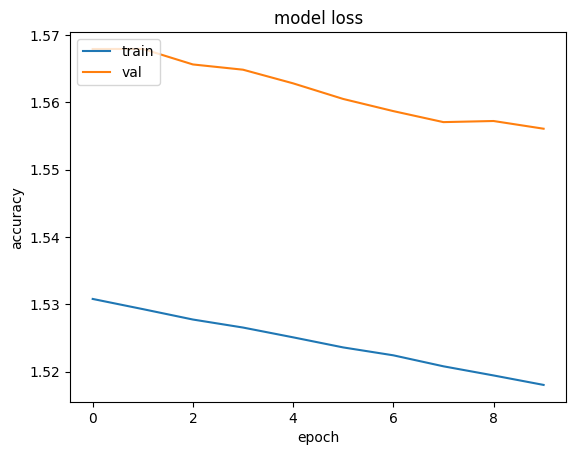

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

## Listing 18-13. A better architecture


In [15]:
import keras
from keras import layers, optimizers
from sklearn.metrics import r2_score

keras.utils.set_random_seed(42)

# --- Model Configuration ---
N_HIDDEN_LAYERS = 2

model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1],), name="features"),
        *[
            layers.Dense(256, activation="relu", kernel_initializer="he_normal")
            for _ in range(N_HIDDEN_LAYERS)
        ],
        layers.Dense(1, name="prediction"),
    ],
    name="very_deep_regressor",
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="mae",
    metrics=["mae"],
)

history = model.fit(
    x=X_train,
    y=y_train,
    # validation_data=(X_test, y_test),
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    shuffle=True,
)

2026/02/25 17:25:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '72da9b9f601545679afbf6d3424d6882', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow
2026/02/25 17:25:46 WARNING mlflow.keras.autologging: Failed to log dataset information to MLflow. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.1673 - mae: 1.1673 - val_loss: 1.0614 - val_mae: 1.0614
Epoch 2/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 1.0501 - mae: 1.0501 - val_loss: 1.0211 - val_mae: 1.0211
Epoch 3/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0237 - mae: 1.0237 - val_loss: 0.9995 - val_mae: 0.9995
Epoch 4/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0019 - mae: 1.0019 - val_loss: 0.9839 - val_mae: 0.9839
Epoch 5/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 0.9846 - mae: 0.9846 - val_loss: 0.9916 - val_mae: 0.9916
Epoch 6/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.9691 - mae: 0.9691 - val_loss: 0.9665 - val_mae: 0.9665
Epoch 7/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.9563 - mae: 0.9563 - val_loss: 0.9544 - val_mae: 0.9544
Epoch 8/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.9442 - mae: 0.9442 - val_loss: 0.9667 - val_mae: 0.9667
Epoch 9/10
7042/7042 ━━━━━━━━━━━

2026/02/25 17:29:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


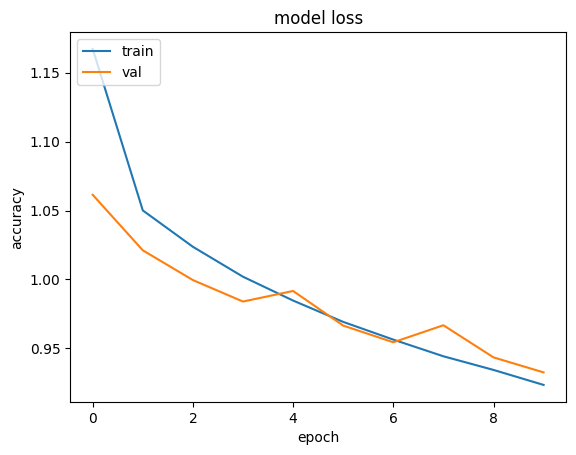

4336/4336 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
R² Score: 0.9778


In [16]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

preds = model.predict(X_test)
print(f"R² Score: {r2_score(preds, y_test):.4f}")